In [29]:
import pandas as pd

movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

print(movies.head())
print(ratings.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64


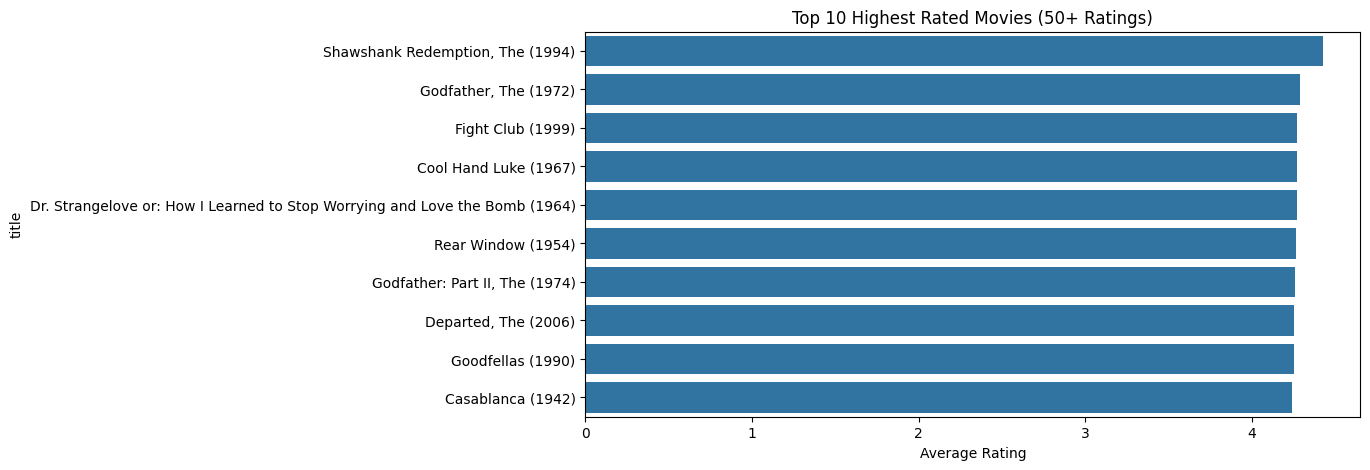

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.merge(ratings, movies, on='movieId')

top_rated = data['title'].value_counts().head(10)
print(top_rated)

movie_stats = data.groupby('title')['rating'].agg(['mean', 'count'])
popular = movie_stats[movie_stats['count'] >= 50].sort_values(by='mean', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=popular.head(10)['mean'], y=popular.head(10).index)
plt.title("Top 10 Highest Rated Movies (50+ Ratings)")
plt.xlabel("Average Rating")
plt.show()


In [31]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)
movies['genres'] = movies['genres'].fillna('')

vectorizer = CountVectorizer()
genre_matrix = vectorizer.fit_transform(movies['genres'])

cosine_sim = cosine_similarity(genre_matrix, genre_matrix)


In [ ]:
title_to_index = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [34]:
def recommend_by_multiple_movies(titles, n=5):

    indices = [title_to_index.get(title) for title in titles if title_to_index.get(title) is not None]
    if not indices:
        print("No movies were found.")
        return

    #Computation of avg similarity vector for all selected movies
    sim_scores = cosine_sim[indices].mean(axis=0)

    #Indice sort
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[0] not in indices]

    top_indices = [i[0] for i in sim_scores[:n]]

    return movies['title'].iloc[top_indices]


In [35]:
recommendations = recommend_by_multiple_movies(["Matrix, The (1999)", "Silence of the Lambs, The (1991)" ], 10)
for i, title in enumerate(recommendations, 1):
    print(f"{i}. {title}")

1. Grindhouse (2007)
2. Lawnmower Man, The (1992)
3. Alien³ (a.k.a. Alien 3) (1992)
4. Thing, The (1982)
5. Godzilla 1985: The Legend Is Reborn (Gojira) (Godzilla) (Return of Godzilla, The) (1984)
6. Deep Blue Sea (1999)
7. RoboCop 2 (1990)
8. Tetsuo, the Ironman (Tetsuo) (1988)
9. Resident Evil (2002)
10. AVP: Alien vs. Predator (2004)


In [36]:
import pandas as pd

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
data = pd.merge(ratings, movies, on="movieId")
data.head()

#Rows= users, columns= movies and values=ratings
user_item_matrix = data.pivot_table(index='userId', columns='title', values='rating')



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

item_similarity = cosine_similarity(user_item_matrix.T.fillna(0))

item_sim_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)


def recommend_similar_movies_multi(titles, n=5):
    valid_titles = [title for title in titles if title in item_sim_df.columns]
    
    if not valid_titles:
        print("No valid movies found.")
        return
    
    sim_scores = item_sim_df[valid_titles].mean(axis=1)

    sim_scores = sim_scores.drop(labels=valid_titles)
    
    return sim_scores.sort_values(ascending=False).head(n)


In [38]:
recommend_similar_movies_multi(["Matrix, The (1999)", "Silence of the Lambs, The (1991)"], 10)

title
Pulp Fiction (1994)                                      0.656514
Fight Club (1999)                                        0.629426
Star Wars: Episode V - The Empire Strikes Back (1980)    0.628984
Forrest Gump (1994)                                      0.624699
Shawshank Redemption, The (1994)                         0.618110
Star Wars: Episode IV - A New Hope (1977)                0.612637
Saving Private Ryan (1998)                               0.606306
Sixth Sense, The (1999)                                  0.594686
Seven (a.k.a. Se7en) (1995)                              0.589067
Star Wars: Episode VI - Return of the Jedi (1983)        0.584797
dtype: float64

In [ ]:
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def recommend_by_user(user_id, n=5):
    similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:]
    top_user = similar_users.index[0]

    user_rated = user_item_matrix.loc[user_id]
    top_user_rated = user_item_matrix.loc[top_user]

    recommendations = top_user_rated[user_rated.isna()].sort_values(ascending=False)
    return recommendations.head(n)

In [40]:
recommend_by_user(user_id=1, n=10)

title
2001: A Space Odyssey (1968)                    5.0
Aliens (1986)                                   5.0
Austin Powers: The Spy Who Shagged Me (1999)    5.0
Blade Runner (1982)                             5.0
Evil Dead II (Dead by Dawn) (1987)              5.0
Commitments, The (1991)                         5.0
Crow, The (1994)                                5.0
Eyes Wide Shut (1999)                           5.0
Fear and Loathing in Las Vegas (1998)           5.0
Dirty Work (1998)                               5.0
Name: 266, dtype: float64

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

#Splitting the data per user
def train_test_split_per_user(ratings, test_size=0.2):
    train_list = []
    test_list = []

    for user_id, group in ratings.groupby('userId'):
        if len(group) >= 5:
            train, test = train_test_split(group, test_size=test_size, random_state=42)
            train_list.append(train)
            test_list.append(test)

    train_data = pd.concat(train_list)
    test_data = pd.concat(test_list)
    return train_data, test_data

train_ratings, test_ratings = train_test_split_per_user(ratings)

train_merged = pd.merge(train_ratings, movies, on="movieId")
user_item_matrix = train_merged.pivot_table(index='userId', columns='title', values='rating')



#item-item 
item_similarity = cosine_similarity(user_item_matrix.T.fillna(0))
item_sim_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

#user-user
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


def precision_recall_at_k(recommended, actual, k):
    recommended = recommended[:k]
    actual_set = set(actual)
    hit_set = set(recommended) & actual_set

    precision = len(hit_set) / len(recommended) if recommended else 0
    recall = len(hit_set) / len(actual_set) if actual_set else 0
    return precision, recall


def evaluate_item_based(k=10):
    precisions, recalls = [], []

    test_grouped = test_ratings.groupby('userId')

    for user_id, group in test_grouped:
        actual_movies = group[group['rating'] >= 4.0]['movieId']
        actual_titles = movies[movies['movieId'].isin(actual_movies)]['title'].tolist()

        if user_id not in user_item_matrix.index:
            continue

        #User's rated movies from training
        user_ratings = user_item_matrix.loc[user_id].dropna()
        input_titles = user_ratings[user_ratings >= 4.0].index.tolist()

        if not input_titles:
            continue

        #Recommendeds
        sim_scores = item_sim_df[input_titles].mean(axis=1).drop(labels=input_titles, errors='ignore')
        recommended = sim_scores.sort_values(ascending=False).head(k).index.tolist()

        #Evaluations
        p, r = precision_recall_at_k(recommended, actual_titles, k)
        precisions.append(p)
        recalls.append(r)

    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)





def evaluate_user_based(k=10):
    precisions, recalls = [], []

    test_grouped = test_ratings.groupby('userId')

    for user_id, group in test_grouped:
        if user_id not in user_item_matrix.index:
            continue

        actual_movies = group[group['rating'] >= 4.0]['movieId']
        actual_titles = movies[movies['movieId'].isin(actual_movies)]['title'].tolist()

        if not actual_titles:
            continue

        #Most similar user to the user
        similar_users = user_sim_df[user_id].sort_values(ascending=False)
        similar_users = similar_users.drop(user_id)
        top_user = similar_users.index[0]

        if top_user not in user_item_matrix.index:
            continue

        #Recommendatiopns
        user_rated_titles = user_item_matrix.loc[user_id].dropna().index
        top_user_ratings = user_item_matrix.loc[top_user].dropna()
        recommendations = top_user_ratings[top_user_ratings >= 4.0].drop(user_rated_titles, errors='ignore')

        if recommendations.empty:
            continue

        recommended = recommendations.sort_values(ascending=False).head(k).index.tolist()

        #Evaluations
        p, r = precision_recall_at_k(recommended, actual_titles, k)
        precisions.append(p)
        recalls.append(r)

    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)



prec, rec = evaluate_item_based(k=10)
print(f"Item-based CF — Precision@10: {prec:.4f}, Recall@10: {rec:.4f}")

prec_user, rec_user = evaluate_user_based(k=10)
print(f"User-based CF — Precision@10: {prec_user:.4f}, Recall@10: {rec_user:.4f}")









Item-based CF — Precision@10: 0.0931, Recall@10: 0.1228
User-based CF — Precision@10: 0.0974, Recall@10: 0.0847


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import numpy as np


user_item_filled = user_item_matrix.fillna(0)
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_item_filled)
item_factors = svd.components_

predicted_ratings_matrix = np.dot(user_factors, item_factors)
predicted_df = pd.DataFrame(predicted_ratings_matrix, index=user_item_filled.index, columns=user_item_filled.columns)

test_merged = pd.merge(test_ratings, movies, on="movieId")

y_true = []
y_pred = []

for _, row in test_merged.iterrows():
    user = row['userId']
    title = row['title']
    actual = row['rating']
    
    #Cold start
    if user in predicted_df.index and title in predicted_df.columns:
        pred = predicted_df.loc[user, title]
        y_true.append(actual)
        y_pred.append(pred)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"SVD (manual) RMSE: {rmse:.4f}")


def evaluate_precision_recall_svd(predicted_df, test_ratings, movies_df, k=10, threshold=4.0):
    precisions = []
    recalls = []

    test_merged = pd.merge(test_ratings, movies_df, on="movieId")
    test_grouped = test_merged.groupby("userId")

    for user_id, group in test_grouped:
        if user_id not in predicted_df.index:
            continue

        actual_movies = group[group["rating"] >= threshold]['title'].tolist()
        if not actual_movies:
            continue

        all_predictions = predicted_df.loc[user_id]
        rated_train_titles = user_item_matrix.loc[user_id].dropna().index
        predictions_filtered = all_predictions.drop(rated_train_titles, errors='ignore')

        recommended = predictions_filtered.sort_values(ascending=False).head(k).index.tolist()

        #Evaluations
        actual_set = set(actual_movies)
        recommended_set = set(recommended)
        hits = actual_set & recommended_set

        precision = len(hits) / len(recommended_set) if recommended_set else 0
        recall = len(hits) / len(actual_set) if actual_set else 0

        precisions.append(precision)
        recalls.append(recall)

    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    return avg_precision, avg_recall

prec_svd, rec_svd = evaluate_precision_recall_svd(predicted_df, test_ratings, movies, k=10, threshold=4.0)
print(f"SVD (manual) — Precision@10: {prec_svd:.4f}, Recall@10: {rec_svd:.4f}")




SVD (manual) RMSE: 3.0008
SVD (manual) — Precision@10: 0.2102, Recall@10: 0.1849
